# Equal Batch Sizes!

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

from sklearn.model_selection import train_test_split

### Creating the Dataset

In [124]:
def create_dataset(number_per_cluster = 200):    
    # generating theta values, setting radius for each cluster
    theta = np.linspace(0, 4*np.pi, number_per_cluster) # interval [0, 4pi]
    radius_1 = 10
    radius_2 = 15

    # generating datasets
    cluster_a = [radius_1*np.cos(theta) + np.random.randn(number_per_cluster)*3,
                radius_1*np.sin(theta) + np.random.randn(number_per_cluster)]

    cluster_b = [radius_2*np.cos(theta) + np.random.randn(number_per_cluster),
                radius_2*np.sin(theta) + np.random.randn(number_per_cluster)*3]

    # hot encoding labels
    labels_np = np.vstack((np.zeros((number_per_cluster,1)), np.ones((number_per_cluster, 1)))) # all of dataset a is labeled as 0, all of b as 1

    # concatenate data into matrix
    data_np = np.hstack((cluster_a,cluster_b)).T

    # convert numpy matrix to pytorch tensor
    data = torch.tensor(data_np).float()
    labels = torch.tensor(labels_np).float()

    return data, labels

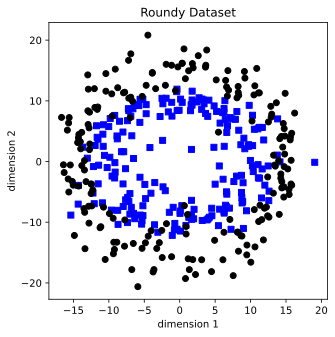

In [125]:
# creating dataset
round_data, round_labels = create_dataset()

# plotting dataset
# plotting data
fig = plt.figure(figsize=(5,5))

plt.plot(round_data[np.where(round_labels==0)[0],0], round_data[np.where(round_labels==0)[0],1], 'bs')
plt.plot(round_data[np.where(round_labels==1)[0],0], round_data[np.where(round_labels==1)[0],1], 'ko')

plt.title('Roundy Dataset')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')

plt.show()

## Data Partitioning and Batches
- Here intentionally there will be uneven batches created in the test dataset.
- There are only two data points in one of the batches. That means there are 3 different possible outcomes.
    1. The model incorrectly classifies one data point. (50% accuracy)
    2. The model incorrectly classifies both data points. (0% accuracy)
    3. The model correctly classifies both data points. (100% accuracy)
- On the graph there will be test accuracy results that show up at any of these 3 outcomes.

In [126]:
# dataset params
test_ratio = 0.2
batch_size = 16 # actually want this to be hard-coded, instead of a ratio of the dataset size

# splitting dataset into training and test set
training_data, test_data, training_labels, test_labels = train_test_split(round_data, round_labels, test_size=test_ratio)

# converting into torch dataset. Maintains relationship between data and labels before being randomly shuffled / sampled
training_dataset = TensorDataset(training_data, training_labels)
test_dataset = TensorDataset(test_data, test_labels)

# creating dataloader
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# creating uneven batches for testing
test_batch_size = test_dataset.tensors[0].shape[0] - 2
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

In [127]:
# Can see uneven batches in test loader
for X, y in test_loader:
    print("X shape: ", X.shape)
    print("y shape: ", y.shape, "\n")

X shape:  torch.Size([78, 2])
y shape:  torch.Size([78, 1]) 

X shape:  torch.Size([2, 2])
y shape:  torch.Size([2, 1]) 



### Creating and Training Model (not the focus of this project)

In [128]:
class categorical_nn(nn.Module):
    def __init__(self):
        super().__init__()

        # layers
        self.input_layer = nn.Linear(2, 128)
        self.hidden_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)

        # forward pass
    def forward(self, x):
        # input layer and dropout
        x = F.relu(self.input_layer(x))
        x = F.dropout(x, training=self.training) # enables if in training mode

        # hidden layer and dropout
        x = F.relu(self.hidden_layer(x))
        x = F.dropout(x, training=self.training)

        # output layer with NO dropout
        x = self.output_layer(x)

        return x

In [129]:
def create_categorical_model(learning_rate):

    # create instance of model class
    model = categorical_nn()

    loss_function = nn.BCEWithLogitsLoss() # binary cross entropy loss

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    return model, loss_function, optimizer

In [130]:
def train_model(model, loss_function, optimizer, number_epochs = 1000):

    # initialize accuracy arrays
    training_accuracy = []
    test_accuracy = []

    # loop through epochs
    for epoch_IDX in range(number_epochs):

        # loop through batches of training data
        train_batch_accuracy = []

        for data, labels in training_loader:

            # forward pass and loss
            y_hat = model(data)
            loss = loss_function(y_hat, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculating batch accuracy
            train_batch_accuracy.append(100*torch.mean(((y_hat>0) == labels).float()).item())

        # calculating accuracy for epoch
        training_accuracy.append(np.mean(train_batch_accuracy))

        # testing model
        test_batch_accuracy = []
        for data, labels in test_loader:
            y_hat = model(data)
            test_batch_accuracy.append(100*torch.mean(((y_hat>0)==labels).float()).item())

        # calculating average accuracy over batches of the test set
        test_accuracy.append(np.mean(test_batch_accuracy))

    return training_accuracy, test_accuracy

## Creating and Training Model

In [131]:
# params
learning_rate = 0.01
epochs = 500

# create and test model
ANN_classify, loss_function, optimizer = create_categorical_model(learning_rate)

training_accuracy, test_accuracy = train_model(ANN_classify, loss_function, optimizer, number_epochs=epochs)

In [132]:
print(f"Shape of training accuracy:", np.shape(training_accuracy))
print(f"Shape of test accuracy:", np.shape(test_accuracy))

Shape of training accuracy: (500,)
Shape of test accuracy: (500,)


In [133]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

### Graphing the Results

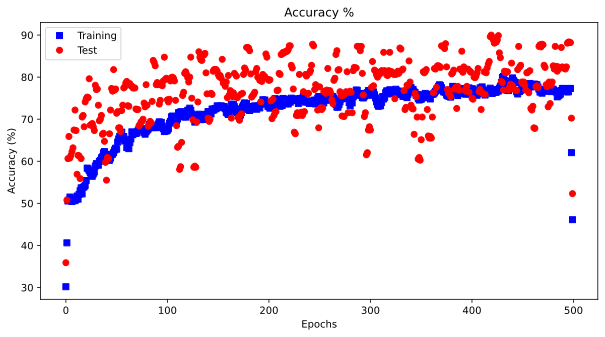

In [134]:
# plotting results of test
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(training_accuracy), 'bs')
plt.plot(smooth(test_accuracy), 'ro')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Training', 'Test'])
plt.title('Accuracy %')
plt.show()

## Examining the Results
- Uneven batches should be avoided at all costs.
- It will skew the averages of the accuracies because there is not the same amount of data points to train or test the model on.
- A sign that this is happening on the graph is there there are 'bands' of points that commonly show up around 0%, 50%, and 100% on the graph. If bands of points are observed at all, that indicates there is definitely something wrong. 
    - In this case uneven batch sizes are the cause.
- This will not give accurate or meaningful results.
- This emphasizes the importance of dropping the last batch if it is a different size than the rest of the batches.